In [126]:
# Import packages
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt

Read in Icepack (output) history file

In [425]:
ds_history = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/history/icepack.h.20150101_default_ic.nc')
ds_history

<xarray.Dataset>
Dimensions:      (ni: 4, ncat: 5, ntrcr: 24, nfsd: 1, time: 87600)
Coordinates:
  * ni           (ni) int32 1 2 3 4
  * ncat         (ncat) int32 1 2 3 4 5
  * ntrcr        (ntrcr) int32 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * nfsd         (nfsd) int32 1
  * time         (time) object 2015-01-01 01:00:00 ... 2025-01-01 00:00:00
Data variables: (12/44)
    timestep     (time) int32 ...
    date         (time) float64 ...
    aice         (time, ni) float64 ...
    vice         (time, ni) float64 ...
    vsno         (time, ni) float64 ...
    uvel         (time, ni) float64 ...
    ...           ...
    d_afsd_latg  (time, nfsd, ni) float64 ...
    d_afsd_latm  (time, nfsd, ni) float64 ...
    d_afsd_wave  (time, nfsd, ni) float64 ...
    d_afsd_weld  (time, nfsd, ni) float64 ...
    trcr         (time, ntrcr, ni) float64 ...
    trcrn        (time, ncat, ntrcr, ni) float64 ...

In CICE the mean ice thickness is$$ h_i = \sum_{n = 1}^{N_c} \textrm{vicen}(n)$$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'model time steps')

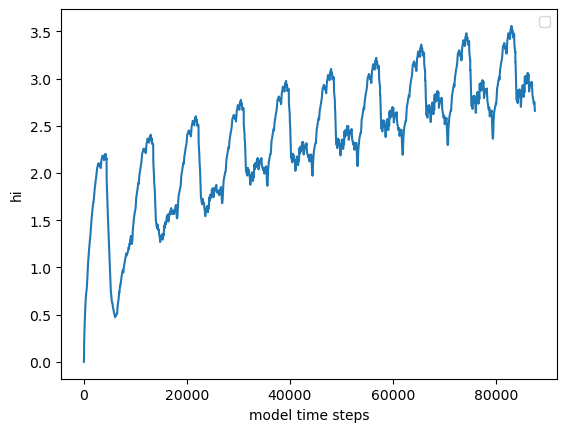

In [452]:
var = 'hi'
column_test = 0

if var == 'hi':
    plot_data = ds_history.vicen.sum(dim='ncat')
else:
    plot_data = ds_history[var]
plt.plot(plot_data[:,column_test])
plt.legend()
plt.ylabel(var)
plt.xlabel('model time steps')

# Editing the intial conditions for a simulation

In [446]:
NCAT = np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00, 1.0000000e+08])

desired_initial_thickness = 0.05 # m
# Open the file
ds_restart = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2016-01-01-00000.nc')
ds_restart
puny = 10**(-12)
thicknesses = ds_restart['vicen'][:,column_test]/ds_restart['aicen'][:,column_test]
temp_aicen = [1.0, puny, puny, puny, puny]*(0.05/thicknesses)
temp_vicen = thicknesses*temp_aicen
temp_vicen.sum()

<xarray.DataArray ()>
array(0.)

From Bitz et al., *JGR*, (2001):
> The thickness-distribution, $g(h)$, for $N_C$ categories is written
> $$ g(h) = g_0\delta(h) + \sum_{i=1}^{N_C} g_i \delta(h-H_i)$$
> where $M$ is the number of ice categories, $\delta(h)$ is the Dirac delta function, $H_i$ is the thickness, and $g_i$ is the concentration within category $i$ (category 0 is open water). $H_i$ varies in time and is constrained to range between the limits $\hat{H}_{i-1}$ to $\hat{H}_i$ (with $\hat{H}_{-1} = 0$, $\hat{H}_0 = 10$ cm, ... $\hat{H}_M = \infty$).

In [447]:
# Verify that the thicknesses do not escape their bins

def constrain_thickneses(vicen_in, aicen_in):
    # NCAT taken from CICE input file
    thicknesses = vicen_in/aicen_in # Bitz
    upper_bounds = np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00, 1.0000000e+08])
    lower_bounds = np.insert(upper_bounds[0:-1], 0, 0)
    thickness_greater = (thicknesses > upper_bounds).all()
    thickness_not_smaller = (thicknesses < lower_bounds).all()

    if (thickness_greater).any():
        print('ERROR: Thickness exceeds upper bounds')
        print(thicknesses)
        print(upper_bounds)
    elif (thickness_not_smaller).any():
        print('ERROR: Thickness subceeds lower bounds')
        print(thicknesses)
        print(lower_bounds)
    else: 
        print('PASSED tests')
    
temp_thickness = np.insert(NCAT[0:-1], 0, 0) + 0.05
PUNY = 10**(-12)
temp_aicen = np.array([1.0 - 4*PUNY, PUNY, PUNY, PUNY, PUNY])
temp_vicen = temp_thickness*temp_aicen
constrain_thickneses(temp_vicen, temp_aicen)
print('Initial ice thicknesses are:',temp_vicen/temp_aicen)

PASSED tests
Initial ice thicknesses are: [0.05       0.69450723 1.4414335  2.5201793  4.6172879 ]


Plot the original ITD and the new ITD

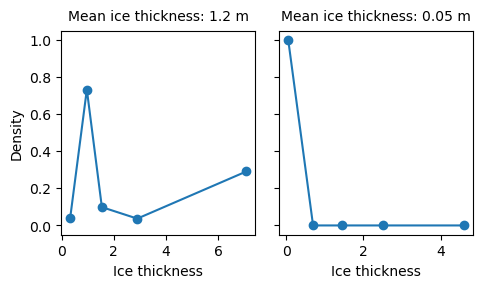

In [453]:
column_test = 0
fig, axes = plt.subplots(1,2, figsize=[5, 3], sharey=True)
axes[0].plot(ds_restart['vicen'][:,column_test]/ds_restart['aicen'][:,column_test], ds_restart['vicen'][:,column_test], 'o-')
axes[0].set_xlabel('Ice thickness')
axes[0].set_ylabel('Density')
axes[0].text(0.5, 1.05, 'Mean ice thickness: ' + str(np.round(ds_restart['vicen'].sum(dim='ncat')[column_test].values, 3))+' m', ha='center', transform=axes[0].transAxes)

axes[1].plot(temp_vicen/temp_aicen, temp_aicen, 'o-')
axes[1].set_xlabel('Ice thickness')
axes[1].text(0.5, 1.05, 'Mean ice thickness: ' + str(np.round(temp_vicen.sum(), 3))+' m', ha='center', transform=axes[1].transAxes)

plt.tight_layout()

If all looks correct, then save the new ITD as a NetCDF4 file.

In [375]:
# Read the NetCDF file
file_path = '/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2016-01-01-00000.nc'
ds_restart = xr.open_dataset(file_path)

# Modify the variables
# Here, we simply demonstrate an example by doubling the values.
# Replace this with your actual modification logic.
ds_temp = ds_restart.copy()
del ds_restart
for column_test in range(4):
    ds_temp['aicen'][:,column_test] = temp_aicen
    ds_temp['vicen'][:,column_test] = temp_vicen

# Save the modified dataset to a new file
new_file_path = '/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced_5cm.2016-01-01-00000.nc'
ds_temp.to_netcdf(new_file_path)

print(f"Modified dataset saved to: {new_file_path}")

Modified dataset saved to: /Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced_5cm.2016-01-01-00000.nc


Verify that the initial conditions have been changed

/var/folders/03/765pb_2s43v72wd74nscd38w0000gn/T/ipykernel_16847/1597128667.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(ds_restart['vicen'][:,column_test]/ds_restart['aicen'][:,column_test], ds_restart['vicen'][:,column_test], 'o-', label = 'Column {}'.format(column_test), linestyle=line_styles[column_test % len(line_styles)])
/var/folders/03/765pb_2s43v72wd74nscd38w0000gn/T/ipykernel_16847/1597128667.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(ds_modified['vicen'][:,column_test]/ds_modified['aicen'][:,column_test], ds_modified['vicen'][:,column_test], 'o-', label = 'Column {}'.format(column_test), linestyle=line_styles[column_test % len(line_styles)])


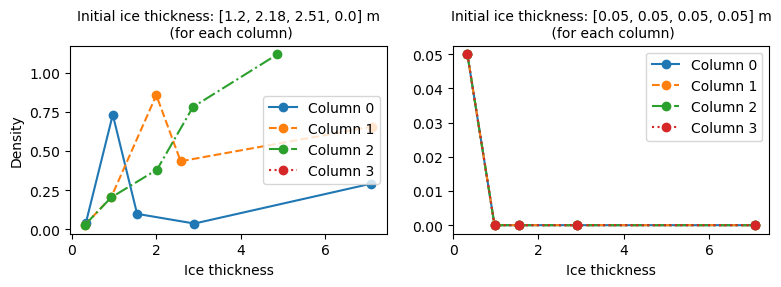

In [439]:
file_path = '/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2016-01-01-00000.nc'
ds_restart = xr.open_dataset(file_path)
file_path = '/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced_5cm.2016-01-01-00000.nc'
ds_modified = xr.open_dataset(file_path)

line_styles = ['-', '--', '-.', ':']

column_test = 1
fig, axes = plt.subplots(1,2, figsize=[8, 3], sharey=False)
for column_test in range(4):
    axes[0].plot(ds_restart['vicen'][:,column_test]/ds_restart['aicen'][:,column_test], ds_restart['vicen'][:,column_test], 'o-', label = 'Column {}'.format(column_test), linestyle=line_styles[column_test % len(line_styles)])
axes[0].set_xlabel('Ice thickness')
axes[0].set_ylabel('Density')
initial_values = []
for column_test in range(4):
    initial_values.append(np.round(ds_restart['vicen'].sum(dim='ncat')[column_test].values, 3))
axes[0].text(0.5, 1.05, 'Initial ice thickness: ' + str(initial_values) +' m\n (for each column)', ha='center', transform=axes[0].transAxes)
axes[0].legend()

for column_test in range(4):
    axes[1].plot(ds_modified['vicen'][:,column_test]/ds_modified['aicen'][:,column_test], ds_modified['vicen'][:,column_test], 'o-', label = 'Column {}'.format(column_test), linestyle=line_styles[column_test % len(line_styles)])
axes[1].set_xlabel('Ice thickness')
initial_values = []
for column_test in range(4):
    initial_values.append(np.round(ds_modified['vicen'].sum(dim='ncat')[column_test].values, 3))
axes[1].text(0.5, 1.05, 'Initial ice thickness: ' +  str(initial_values) +' m\n (for each column)', ha='center', transform=axes[1].transAxes)
axes[1].legend()
plt.tight_layout()

Evaluate Icepack outputs using the initial  conditions

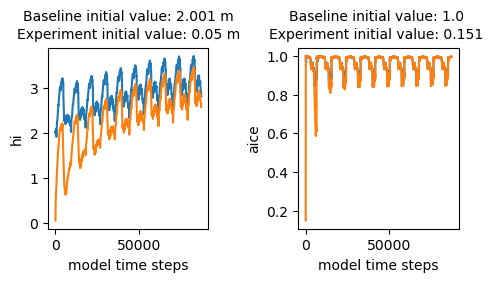

In [437]:
def get_icepack_var(ds_history, var, column_test=1):
    if var == 'hi':
        plot_data = ds_history.vicen.sum(dim='ncat')
    else:
        plot_data = ds_history[var]
    return plot_data[:,column_test]

ds_baseline = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/history/icepack.h.20150101_default_ic.nc')
ds_baseline

ds_experiment= xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/history/icepack.h.20160101.nc')
ds_experiment


fig, axes = plt.subplots(1,2, figsize=[5, 3], sharex=True)
var = 'hi'
axes[0].plot(get_icepack_var(ds_baseline, var))
axes[0].plot(get_icepack_var(ds_experiment, var))
axes[0].set_ylabel(var)
axes[0].set_xlabel('model time steps')
axes[0].text(0.5, 1.15, 'Baseline initial value: ' + str(np.round(get_icepack_var(ds_baseline, var)[0].values, 3))+' m', ha='center', transform=axes[0].transAxes)
axes[0].text(0.5, 1.05, 'Experiment initial value: ' + str(np.round(get_icepack_var(ds_experiment, var)[0].values, 3))+' m', ha='center', transform=axes[0].transAxes)


var = 'aice'
axes[1].plot(get_icepack_var(ds_baseline, var))
axes[1].plot(get_icepack_var(ds_experiment, var))
axes[1].set_ylabel(var)
axes[1].text(0.5, 1.15, 'Baseline initial value: ' + str(np.round(get_icepack_var(ds_baseline, var)[0].values, 3))+' ', ha='center', transform=axes[1].transAxes)
axes[1].text(0.5, 1.05, 'Experiment initial value: ' + str(np.round(get_icepack_var(ds_experiment, var)[0].values, 3))+' ', ha='center', transform=axes[1].transAxes)
axes[1].set_xlabel('model time steps')

plt.tight_layout()